In [1]:
import torch
from torch import nn

# 模型架构

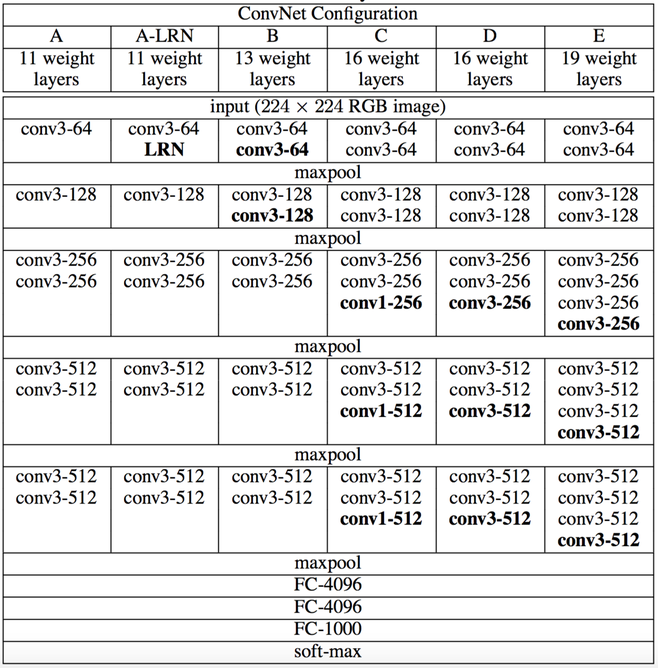

论文中（见4.1节）证明了LRN作用不大，所有B到E模型中都没有使用它。
C网络比B网络效果好点，但是却不如D网网络来得明显。证明1x1卷积虽然有助于增加非线性效果稍微好点，但是不如直接采用3x3的卷积效果来的更好，所以1x1卷积一般用来改变通道数，而不用作提取特征的卷积。

所以这里实现 A、B、D、E的 VGG 网络而不实现A-LRN和C网络。即对应vgg11、vgg13、vgg16、vgg19。

模型的网络架构，输入固定大小 224x224 的RGB图像。每一层的卷积层的核大小都是一样的（3x3），每一层卷积都输出都保持分辨率，根据公式：

$$ \lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor $$

- $n_h$：表示输入图像（特征图）的高
- $k_h$：表示卷积核的高
- $p_h$：表示高方向的填充
- $s_h$：表示高方向的步幅

为了保证卷积前后的分辨率不变，那么应该让步幅为1，因为卷积核为3，所以让 $p_h$ 为2 即 padding=1，即可保证这一点。

每次通过maxpool 最大池化层之后特征图高宽减半，即maxpool的核大小为2，步长为2。

卷积层之后是3个全连接层。

所有隐藏层的激活函数都是ReLU函数。

输入是224x224x3，经过5次最大池化层之后，即：$224/(2^5)=7$，变为 7x7x512。

In [2]:
model_conf = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class MyVGG(nn.Module):
    def __init__(self, model_name='vgg16', num_classes = 1000, dropout = 0.5):
        super().__init__()
        conv_list = []
        input_ch = 3
        for item in model_conf[model_name]:
            if item == 'M':
                conv_list.append(nn.MaxPool2d(2, stride=2))                
            else:
                output_ch=item
                conv_list.append(nn.Conv2d(input_ch, output_ch, kernel_size=3, stride=1, padding=1))
                conv_list.append(nn.ReLU(True))
                input_ch = output_ch
        # 卷积层
        self.conv_layer = nn.Sequential(*conv_list)
        # 这里单独把Flatten 拿出来，不放到全连接层中，是为了和torchvision库中的全连接层对应
        # 可以直接匹配 state_dict 字典，直接load，否则需要额外的操作
        self.flatten = nn.Flatten()
        # 全连接层层
        self.fc_layer = nn.Sequential(
            nn.Linear(7 * 7 * 512, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.flatten(x)
        return self.fc_layer(x)

In [3]:
a = torch.randn((64, 3, 224, 224))

MyVGG('vgg11')(a).shape, MyVGG('vgg13')(a).shape, MyVGG('vgg16')(a).shape, MyVGG('vgg19')(a).shape

(torch.Size([64, 1000]),
 torch.Size([64, 1000]),
 torch.Size([64, 1000]),
 torch.Size([64, 1000]))

# 加载pytorch官方的权重文件并替换为自己的

In [4]:
import torchvision
from torchvision.models.vgg import VGG11_Weights

In [5]:
tvgg11 = torchvision.models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1)
mvgg11 = MyVGG('vgg11')
for km, kt in zip(mvgg11.state_dict(), tvgg11.state_dict()):
    print(f"{km} <==> {kt}")

conv_layer.0.weight <==> features.0.weight
conv_layer.0.bias <==> features.0.bias
conv_layer.3.weight <==> features.3.weight
conv_layer.3.bias <==> features.3.bias
conv_layer.6.weight <==> features.6.weight
conv_layer.6.bias <==> features.6.bias
conv_layer.8.weight <==> features.8.weight
conv_layer.8.bias <==> features.8.bias
conv_layer.11.weight <==> features.11.weight
conv_layer.11.bias <==> features.11.bias
conv_layer.13.weight <==> features.13.weight
conv_layer.13.bias <==> features.13.bias
conv_layer.16.weight <==> features.16.weight
conv_layer.16.bias <==> features.16.bias
conv_layer.18.weight <==> features.18.weight
conv_layer.18.bias <==> features.18.bias
fc_layer.0.weight <==> classifier.0.weight
fc_layer.0.bias <==> classifier.0.bias
fc_layer.3.weight <==> classifier.3.weight
fc_layer.3.bias <==> classifier.3.bias
fc_layer.6.weight <==> classifier.6.weight
fc_layer.6.bias <==> classifier.6.bias


In [6]:
# 获取fc_连接层的权重，形成dict
# 虽然他们的需要设置的就是三个全连接层的权重，但是他们的名字不是对应的
# 所以需要这样操作形成一个名称和权重对应的字典，方便更新
# fc_weight = {}
# for km, kt in zip(mvgg11.fc_layer.state_dict(), tvgg11.classifier.state_dict()):
#     fc_weight[km] = tvgg11.classifier.state_dict()[kt]

In [7]:
# # 复制 conv 层的特征
# vgg11.conv_layer.load_state_dict(tvgg11.features.state_dict())
# # 复制 fc 层的特征
# vgg11.fc_layer.load_state_dict(fc_weight)

In [8]:
mvgg11.conv_layer.load_state_dict(tvgg11.features.state_dict())
mvgg11.fc_layer.load_state_dict(tvgg11.classifier.state_dict())

<All keys matched successfully>

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

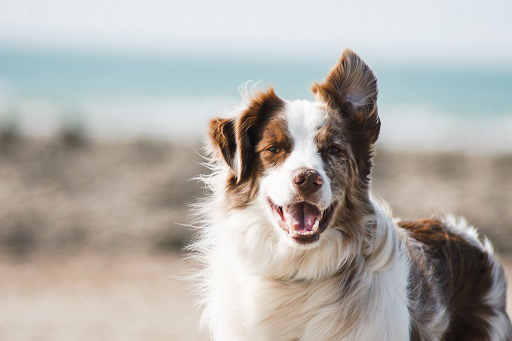

In [10]:
catImg = Image.open('./img/cat.jpg')
dogImg = Image.open('./img/dog.jpg')
dogImg

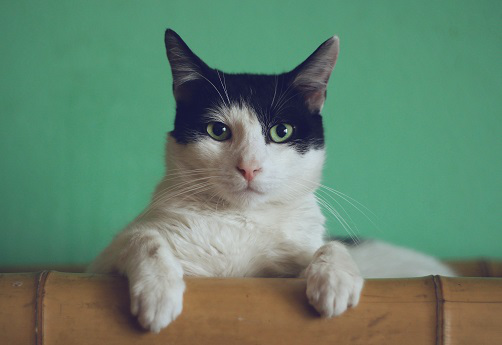

In [11]:
catImg

In [12]:
from torchvision.transforms._presets import ImageClassification
from torchvision.models._meta import _IMAGENET_CATEGORIES

In [13]:
ic_transforms = ImageClassification(crop_size=224)
x = torch.stack((ic_transforms(dogImg), ic_transforms(catImg)))
x.shape

torch.Size([2, 3, 224, 224])

ImageClassification 是一组对图片的变化，前向推理的源码如下：
```python
def forward(self, img: Tensor) -> Tensor:
    img = F.resize(img, self.resize_size, interpolation=self.interpolation)
    img = F.center_crop(img, self.crop_size)
    if not isinstance(img, Tensor):
        img = F.pil_to_tensor(img)
    img = F.convert_image_dtype(img, torch.float)
    img = F.normalize(img, mean=self.mean, std=self.std)
    return img
```
1. 首先进行resize，resize 到255的大小（默认参数）
2. 然后进行center_crop，中心裁剪出224*224的分辨率图片
3. 然后判断是否是tensor，如果不是，那么转换一下
4. 转换图像的数值到forch.float 类型
5. 对图像进行 normalize 标准化，默认 mean:(0.485, 0.456, 0.406),std:(0.229, 0.224, 0.225), 这是 ImageNet 数据集的 均值和方差

In [14]:
def model_predict_topk(model, x, k):
    model.eval()
    output = nn.Softmax(model(x)).dim
    prob, pred = torch.topk(output, k, sorted=True)
    name_pred = []
    for item in pred:
        name_pred.append([_IMAGENET_CATEGORIES[i] for i in item])
    return name_pred, prob.tolist()

In [15]:
mPred, mProb = model_predict_topk(mvgg11, x, 5)
mPred, mProb

([['Border collie',
   'Brittany spaniel',
   'collie',
   'papillon',
   'English springer'],
  ['Egyptian cat', 'tabby', 'plastic bag', 'Siamese cat', 'lynx']],
 [[17.191434860229492,
   15.45160961151123,
   15.154565811157227,
   14.588627815246582,
   13.798844337463379],
  [9.650203704833984,
   8.439962387084961,
   8.12686824798584,
   7.946557521820068,
   7.874702453613281]])

In [16]:
model_predict_topk(tvgg11, x, 5)

([['Border collie',
   'Brittany spaniel',
   'collie',
   'papillon',
   'English springer'],
  ['Egyptian cat', 'tabby', 'plastic bag', 'Siamese cat', 'lynx']],
 [[17.191434860229492,
   15.45160961151123,
   15.154565811157227,
   14.588627815246582,
   13.798844337463379],
  [9.650203704833984,
   8.439962387084961,
   8.12686824798584,
   7.946557521820068,
   7.874702453613281]])

# test AdaptiveAvgPool2d


In [17]:
dd = torch.ones((2,8,16,16))
dd.shape

torch.Size([2, 8, 16, 16])

In [18]:
dd.flatten()

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [19]:
sum(dd.flatten() == nn.AdaptiveAvgPool2d((16, 16))(dd).flatten()) == 2*8*16*16

tensor(True)

# torchvision 中 vgg 的结构
源码如下：

```python
class VGG(nn.Module):
    def __init__(
        self, features: nn.Module, num_classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
```

In [20]:
tvgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

torchvision中实现解析：
1. 可以看到在torchvision中， flatten 操作实际上不算做是一层，所以并没有写到类的属性中。实际上，flatten 操作仅仅只是把向量拉长罢了，改变了数据的形状，对数值没有更改，所以不算做一层也是很合理的
2. 全局平均池化层，输出7x7分辨率的特征图，原本的vgg论文中是没有该操作的，这是为了适应不同分辨率的输入。所以当输入图片的分辨率和原始论文中要求输入的图片的分辨率一致时，全局平均池化层就没有作用了。因为此时 全局平均池化层 输入(就是卷积层的输出)和输出的特征图的分辨率一致，都是7x7（$224/(2^5)=7$）

# 为什么不把 Flatten 放到全连接层中？

可以放，只不过加载官方的全连接层的权重时，需要额外操作，不能直接load。
假设把 flatten 放到全连接层中，我们将得到这样的网络模型：

In [21]:
class TmpMyVGG(nn.Module):
    def __init__(self, model_name='vgg16', num_classes = 1000, dropout = 0.5):
        super().__init__()
        conv_list = []
        input_ch = 3
        for item in model_conf[model_name]:
            if item == 'M':
                conv_list.append(nn.MaxPool2d(2, stride=2))                
            else:
                output_ch=item
                conv_list.append(nn.Conv2d(input_ch, output_ch, kernel_size=3, stride=1, padding=1))
                conv_list.append(nn.ReLU(True))
                input_ch = output_ch
        # 卷积层
        self.conv_layer = nn.Sequential(*conv_list)
        # 全连接层
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 512, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        return self.fc_layer(x)


tmvgg11 = TmpMyVGG('vgg11')
tmvgg11

TmpMyVGG(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

观察全连接层，可以发现多了一层Flatten，此时不能直接通过 `tmvgg11.fc_layer.load_state_dict` 函数直接加载，因为他们的key不对应,刚好相差1.

In [22]:
tmvgg11.fc_layer.state_dict().keys(), tvgg11.classifier.state_dict().keys()

(odict_keys(['1.weight', '1.bias', '4.weight', '4.bias', '7.weight', '7.bias']),
 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias']))

但是非要这样写也好解决，通过构造 state_dict ，构造我们模型的层的参数名称，对应到相应权重即可，做法如下：

In [23]:
# state_dict for update weights
fc_weight = {}
for km, kt in zip(tmvgg11.fc_layer.state_dict(), tvgg11.classifier.state_dict()):
    fc_weight[km] = tvgg11.classifier.state_dict()[kt]

In [24]:
# 复制 conv 层的特征
tmvgg11.conv_layer.load_state_dict(tvgg11.features.state_dict())
# 复制 fc 层的特征
tmvgg11.fc_layer.load_state_dict(fc_weight)

<All keys matched successfully>

In [25]:
# 进行预测验证，结果和之前是一样的
model_predict_topk(tmvgg11, x, 5)

([['Border collie',
   'Brittany spaniel',
   'collie',
   'papillon',
   'English springer'],
  ['Egyptian cat', 'tabby', 'plastic bag', 'Siamese cat', 'lynx']],
 [[17.191434860229492,
   15.45160961151123,
   15.154565811157227,
   14.588627815246582,
   13.798844337463379],
  [9.650203704833984,
   8.439962387084961,
   8.12686824798584,
   7.946557521820068,
   7.874702453613281]])